# Filtering functions

In [21]:
import pandas as pd

df_tox = pd.read_csv('datasets/toxins_sprot_clean.tsv', sep = '\t')
df_non_tox = pd.read_csv('datasets/non_toxins_sprot_clean.tsv', sep = '\t')

In [ ]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, regex as re

sns.set_theme(style="whitegrid", rc={"figure.dpi": 110})
_r_split   = re.compile(r"[;,]")                      # delimiter → , or ;
_r_extract = re.compile(r"\s*(.*?)\s*\(([^()]+)\)\s*$")  # "<name> (<rank>)"

def parse_lineage(lineage_str: str) -> dict:
    """
    Return {rank: name, ...}  for one lineage string such as
    'Mollusca (phylum), Gastropoda (class), Conidae (family)'.
    Unknown or 'no rank' tokens are ignored.
    """
    if pd.isna(lineage_str):
        return {}
    ranks = {}
    for token in _r_split.split(lineage_str):
        m = _r_extract.match(token)
        if m:
            name, rank = m.groups()
            ranks[rank.strip().lower()] = name.strip()
    return ranks


def get_rank(lineage_str: str, wanted: str = "class"):
    """Return the *wanted* rank (case-insensitive) or None if absent."""
    return parse_lineage(lineage_str).get(wanted.lower())


# ------------------------------------------------------------------ #
# 2.  revised visual explorer
# ------------------------------------------------------------------ #
def explore_dataset(
    df: pd.DataFrame,
    data_name: str         = "",
    tax_rank: str          = "class",    # phylum | class | order | family …
    top_n: int             = 50,
    length_col: str        = "Length",
    lineage_col: str       = "Taxonomic lineage",
    organism_col: str      = "Organism",
    palette: str           = "viridis",
):
    # ----- LENGTH HISTOGRAM --------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(np.log10(df[length_col]), kde=True,
                 bins=75, color=sns.color_palette(palette)[3], ax=ax)
    ax.set(title=f"{data_name} · Length distribution (log₁₀ aa)",
           xlabel="log₁₀(sequence length)", ylabel="Count")
    sns.despine(); plt.tight_layout(); plt.show()

    # ----- TAXONOMIC COUNTS ---------------------------------------------------
    if lineage_col in df.columns and df[lineage_col].notna().any():
        df[f"{tax_rank}_tmp"] = df[lineage_col].apply(get_rank, wanted=tax_rank)
    else:                       # fall back to plain organism name
        df[f"{tax_rank}_tmp"] = df[organism_col]

    counts = (df[f"{tax_rank}_tmp"]
              .value_counts(dropna=True)
              .head(top_n)
              .rename_axis(tax_rank)
              .reset_index(name="Count"))

    if counts.empty:
        print(f"[warn] No non-empty values found for rank “{tax_rank}”. "
              "Check lineage strings or choose another rank."); return

    # ----- BAR-PLOT -----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, max(3, 0.35*len(counts))))
    sns.barplot(data=counts, y=tax_rank, x="Count",
                palette=palette, ax=ax)
    ax.set(title=f"{data_name} · Top {top_n} {tax_rank.title()}s",
           xlabel="Number of sequences")
    for i in range(len(counts)):    
        ax.bar_label(ax.containers[i], fmt="%.0f", label_type="edge", padding=3)
    plt.tight_layout(); plt.show()

    # ----- COVERAGE CURVE -----------------------------------------------------
    cum_frac = counts["Count"].cumsum() / counts["Count"].sum()
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(cum_frac)+1), cum_frac, marker="o")
    ax.set(title=f"{data_name} · Coverage by top {tax_rank.title()}s",
           xlabel=f"Top N {tax_rank.title()}s", ylabel="Cumulative fraction")
    ax.axhline(0.8, ls="--", lw=0.8, color="grey")
    ax.text(0.5, 0.82, "80 % mark",
            transform=ax.get_yaxis_transform(), ha="left", fontsize=9)
    sns.despine(); plt.tight_layout(); plt.show()

# ---------- NEW utility ----------

def filter_by_top_taxa(df_a, df_b,
                       rank="family",
                       n_top=20,
                       lineage_col="Taxonomic lineage",
                       organism_col="Organism",
                       match_counts=True,
                       random_state=42):
    """
    Return (subset_a, subset_b) where subset_b contains only the top-N taxa
    chosen from df_a at the requested rank ('family', 'class', ...).
    If match_counts=True, subset_b is down-sampled per taxon to the same size
    as in subset_a (useful for balanced comparisons).
    """

    # 1) add rank column to both dataframes
    df_a = df_a.copy()
    df_b = df_b.copy()
    df_a[rank] = df_a[lineage_col].apply(get_rank, wanted=rank)
    df_b[rank] = df_b[lineage_col].apply(get_rank, wanted=rank)

    # 2) identify top-N taxa in df_a
    top_taxa = (
        df_a[rank].value_counts()
        .head(n_top)
        .index.tolist()
    )

    # 3) subset dataframes
    sub_a = df_a[df_a[rank].isin(top_taxa)].copy()
    sub_b = df_b[df_b[rank].isin(top_taxa)].copy()

    # 4) optionally match sample counts per taxon
    if match_counts:
        matched_rows = []
        rng = np.random.RandomState(random_state)         
        for fam, n_needed in sub_a[rank].value_counts().items():
            pool = sub_b[sub_b[rank] == fam]
            if len(pool) >= n_needed:
                matched_rows.append(pool.sample(n_needed, random_state=rng))
            else:
                # keep all available if not enough to match
                matched_rows.append(pool)
        sub_b = pd.concat(matched_rows, ignore_index=True)

    return sub_a, sub_b


def compare_family_bars(sub_a, sub_b, rank="family", palette="Set2"):
    """
    Quick bar-plot of family counts (after filtering) for each dataset.
    """
    cnt_a = sub_a[rank].value_counts().rename("A")
    cnt_b = sub_b[rank].value_counts().rename("B")
    comp  = pd.concat([cnt_a, cnt_b], axis=1).fillna(0).astype(int)

    comp.sort_values("A", ascending=False, inplace=True)
    comp = comp.reset_index().melt(id_vars=rank,
                                   var_name="Dataset", value_name="Count")

    sns.set_theme(style="whitegrid", rc={"figure.dpi": 110})
    plt.figure(figsize=(10, 0.4 * comp[rank].nunique() + 2))
    sns.barplot(
        data=comp, y=rank, x="Count",
        hue="Dataset", palette=palette
    )
    plt.title(f"Top {rank.title()}s – dataset comparison")
    plt.xlabel("Number of sequences"); plt.ylabel(rank.title())
    plt.legend(title="")
    sns.despine(); plt.tight_layout(); plt.show()

# PHYLUM

C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:49: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


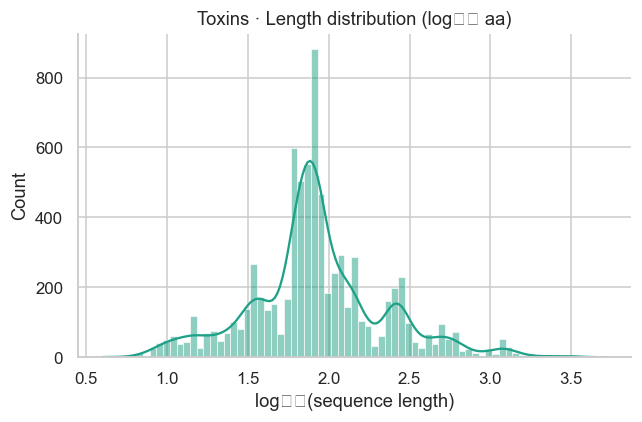

C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, y=tax_rank, x="Count",


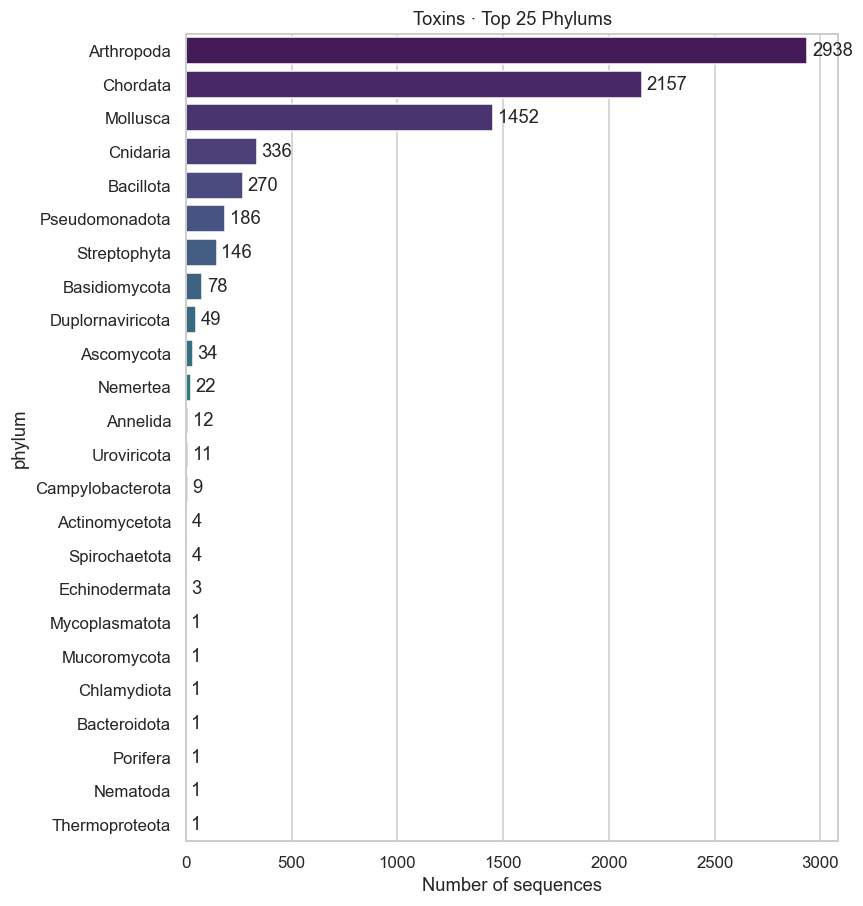

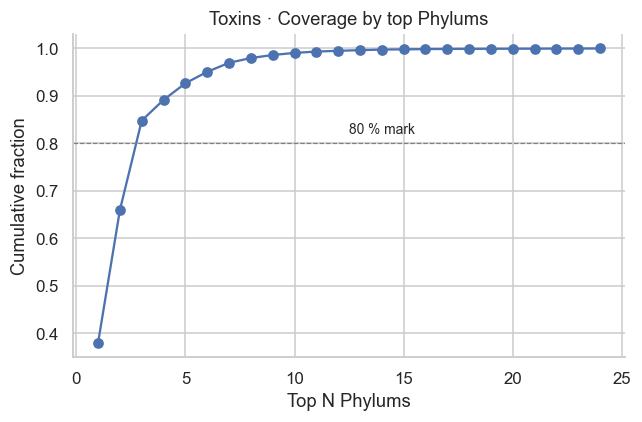

In [35]:
explore_dataset(df_tox, 
                data_name='Toxins', 
                tax_rank='phylum', 
                top_n=25)

C:\Users\manuf\AppData\Local\Temp\ipykernel_24088\2913117885.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
C:\Users\manuf\AppData\Local\Temp\ipykernel_24088\2913117885.py:49: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


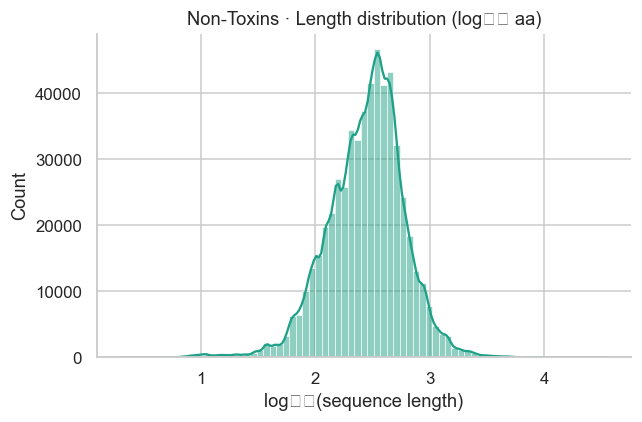

C:\Users\manuf\AppData\Local\Temp\ipykernel_24088\2913117885.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, y=tax_rank, x="Count",


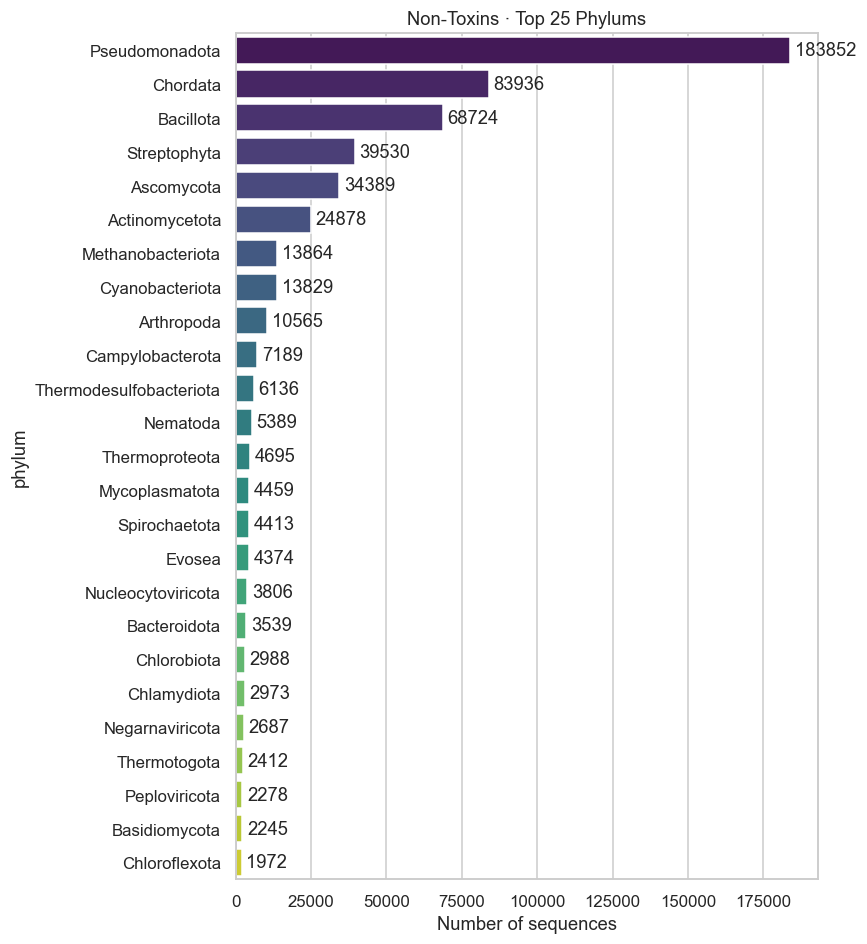

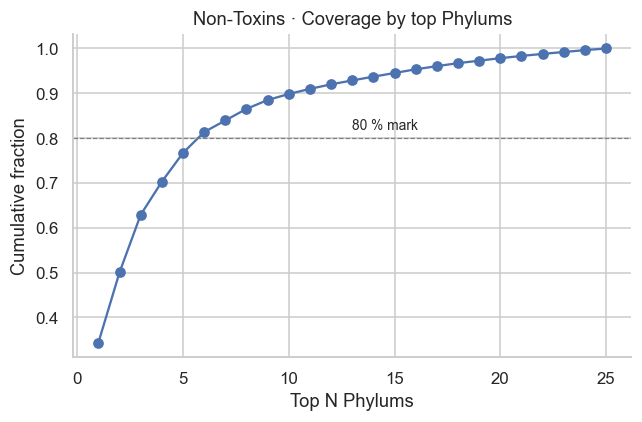

In [22]:
explore_dataset(df_non_tox, 
                data_name='Non-Toxins',
                tax_rank='phylum', 
                top_n=25)

sizes ➜ 7714 6952


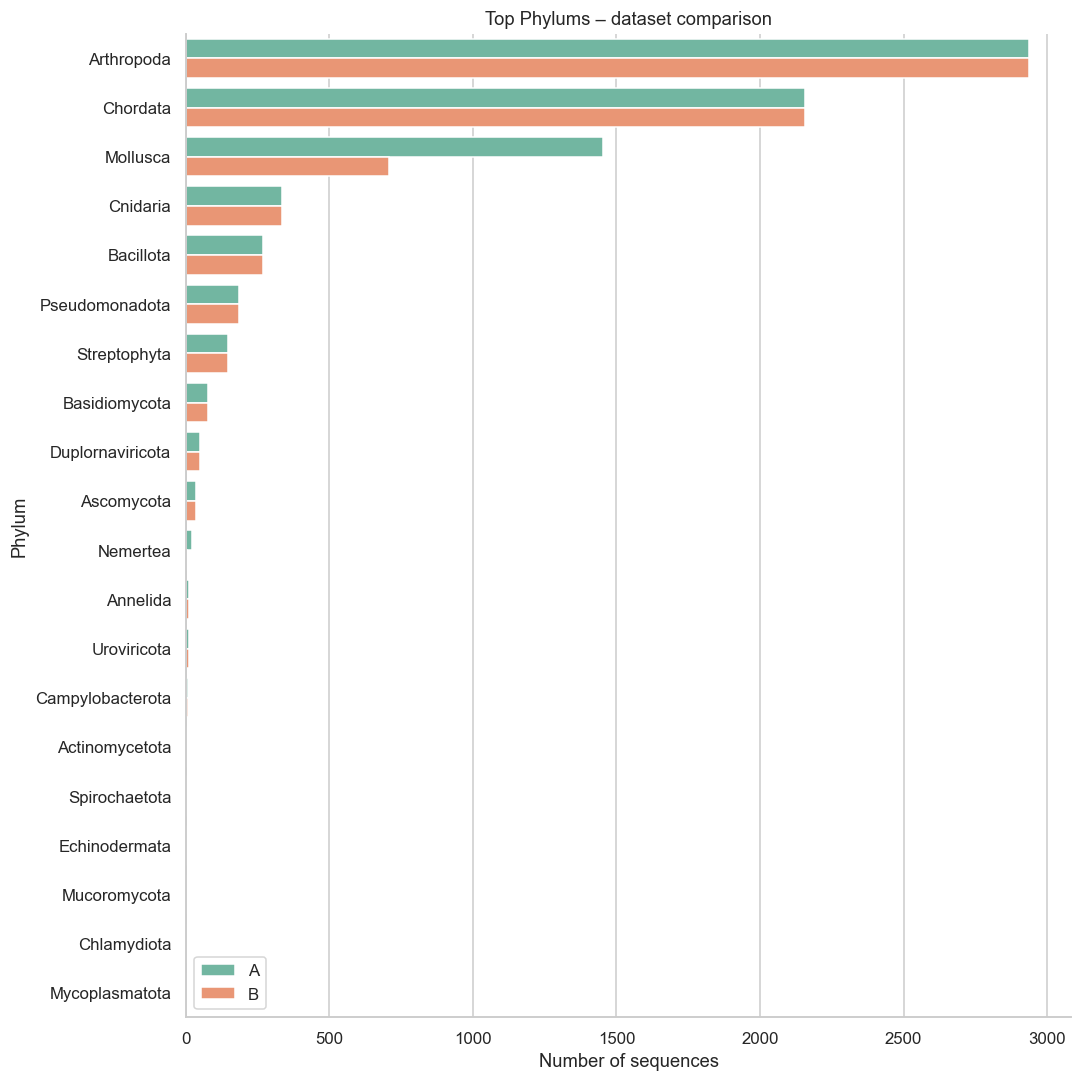

In [20]:
tox_fam, nontox_fam = filter_by_top_taxa(
    df_tox, df_non_tox,
    rank="phylum",
    n_top=20,
    lineage_col="Taxonomic lineage",
    match_counts=True     # False if you just want to keep *all* matches
)

print("sizes ➜", len(tox_fam), len(nontox_fam))

# 2. visual check
compare_family_bars(tox_fam, nontox_fam, rank="phylum")

# CLASS

In [ ]:
explore_dataset(df_tox, 
                data_name='Toxins', 
                tax_rank='class', 
                top_n=25)

In [ ]:
explore_dataset(df_non_tox, 
                data_name='Non Toxins', 
                tax_rank='class', 
                top_n=25)

sizes ➜ 7636 3186


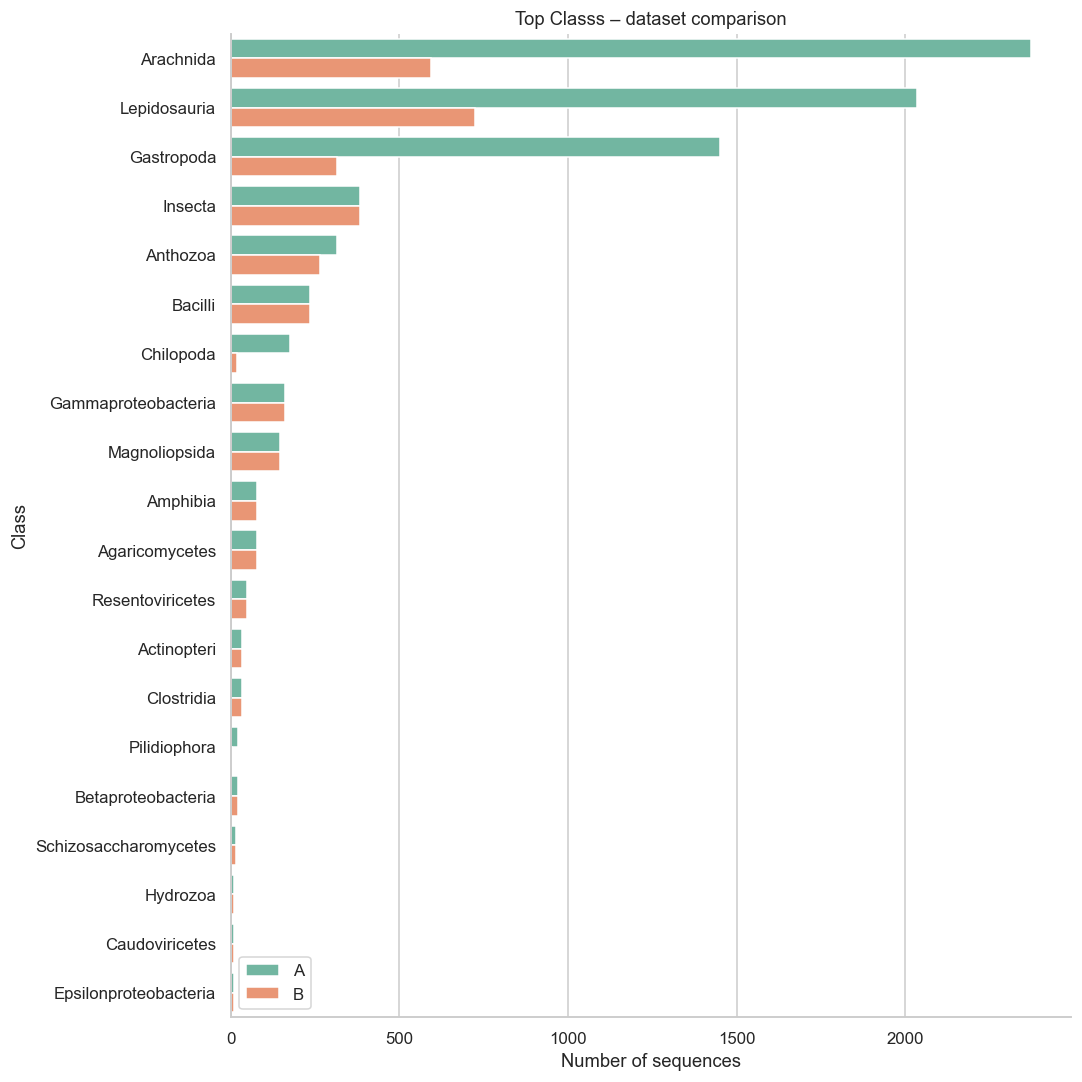

In [11]:
tox_fam, nontox_fam = filter_by_top_taxa(
    df_tox, df_non_tox,
    rank="class",
    n_top=20,
    lineage_col="Taxonomic lineage",
    match_counts=True     # False if you just want to keep *all* matches
)

print("sizes ➜", len(tox_fam), len(nontox_fam))

# 2. visual check
compare_family_bars(tox_fam, nontox_fam, rank="class")

# FAMILY

C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:49: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:49: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  sns.despine(); plt.tight_layout(); plt.show()
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\manuf\miniconda3\envs\plmTox\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


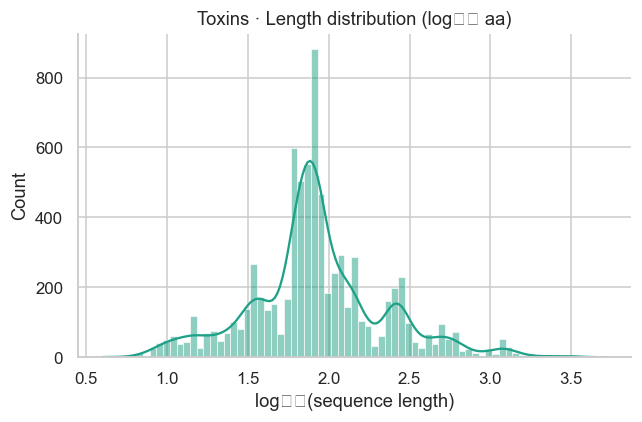

C:\Users\manuf\AppData\Local\Temp\ipykernel_13524\999226634.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, y=tax_rank, x="Count",


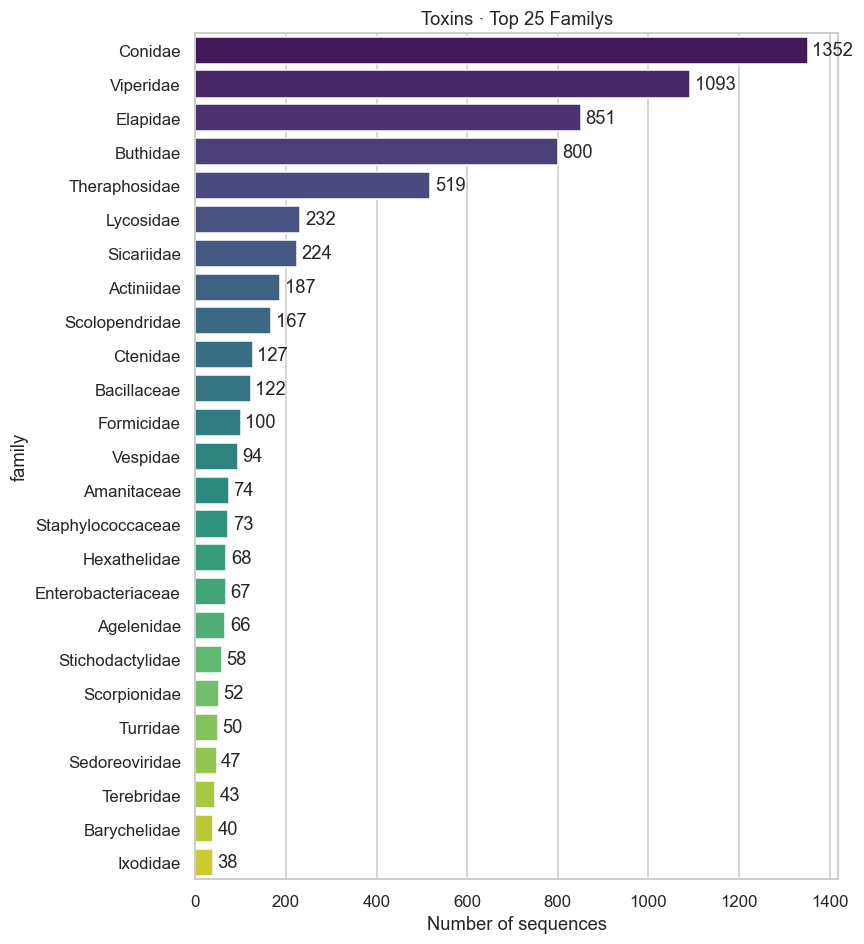

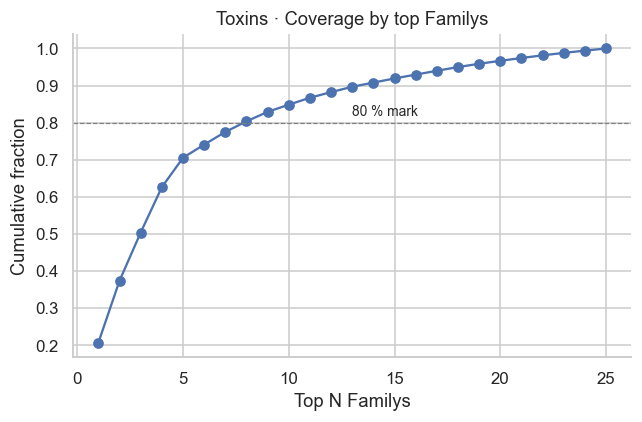

In [37]:
explore_dataset(df_tox, 
                data_name='Toxins', 
                tax_rank='family', 
                top_n=25)

In [ ]:
explore_dataset(df_non_tox, 
                data_name='Non Toxins', 
                tax_rank='family', 
                top_n=25)

sizes ➜ 6326 1309


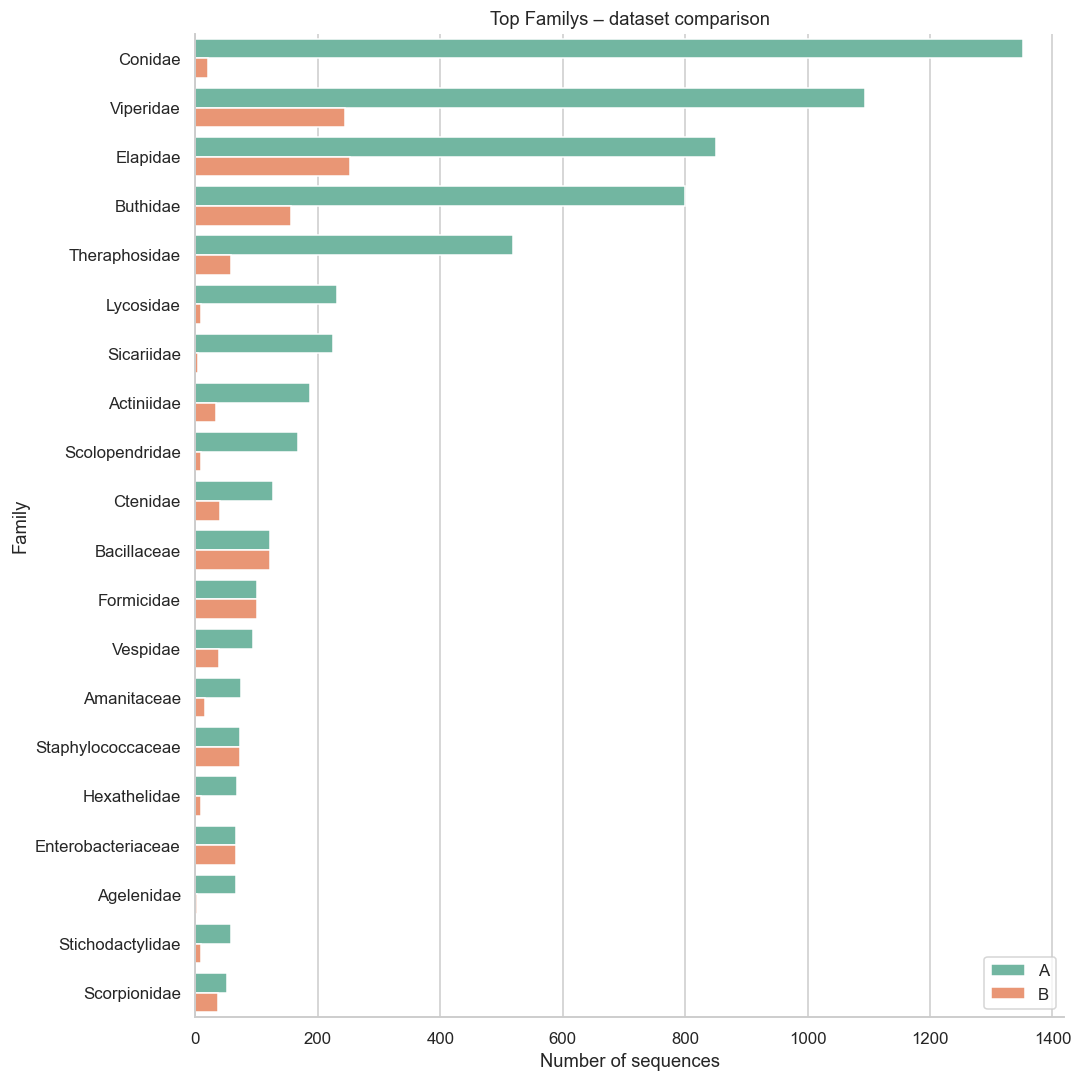

In [10]:
tox_fam, nontox_fam = filter_by_top_taxa(
    df_tox, df_non_tox,
    rank="family",
    n_top=20,
    lineage_col="Taxonomic lineage",
    match_counts=True     # False if you just want to keep *all* matches
)

print("sizes ➜", len(tox_fam), len(nontox_fam))

# 2. visual check
compare_family_bars(tox_fam, nontox_fam, rank="family")

# GENUS

sizes ➜ 3897 469


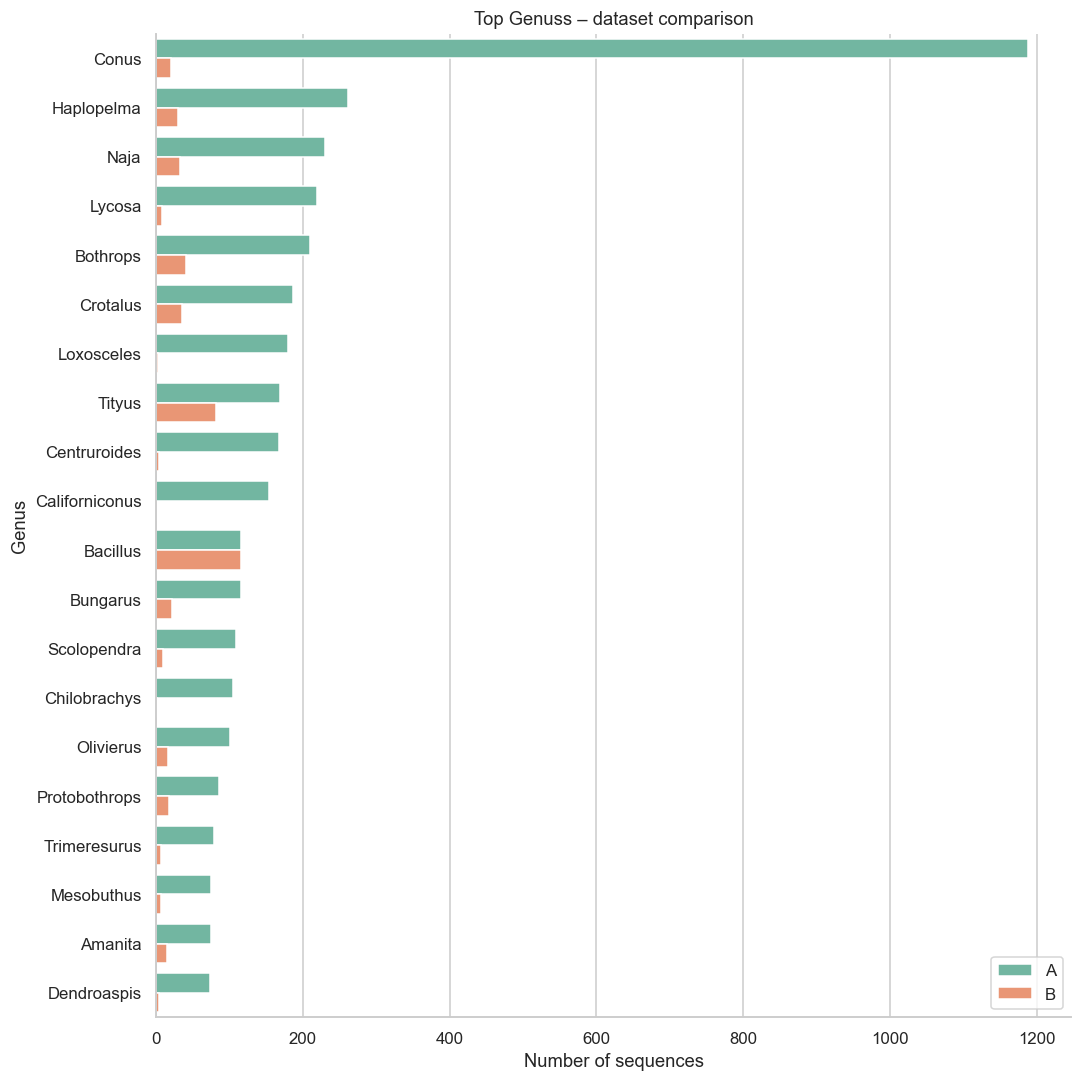

In [9]:
tox_fam, nontox_fam = filter_by_top_taxa(
    df_tox, df_non_tox,
    rank="genus",
    n_top=20,
    lineage_col="Taxonomic lineage",
    match_counts=True     # False if you just want to keep *all* matches
)

print("sizes ➜", len(tox_fam), len(nontox_fam))

# 2. visual check
compare_family_bars(tox_fam, nontox_fam, rank="genus")

sizes ➜ 461 265


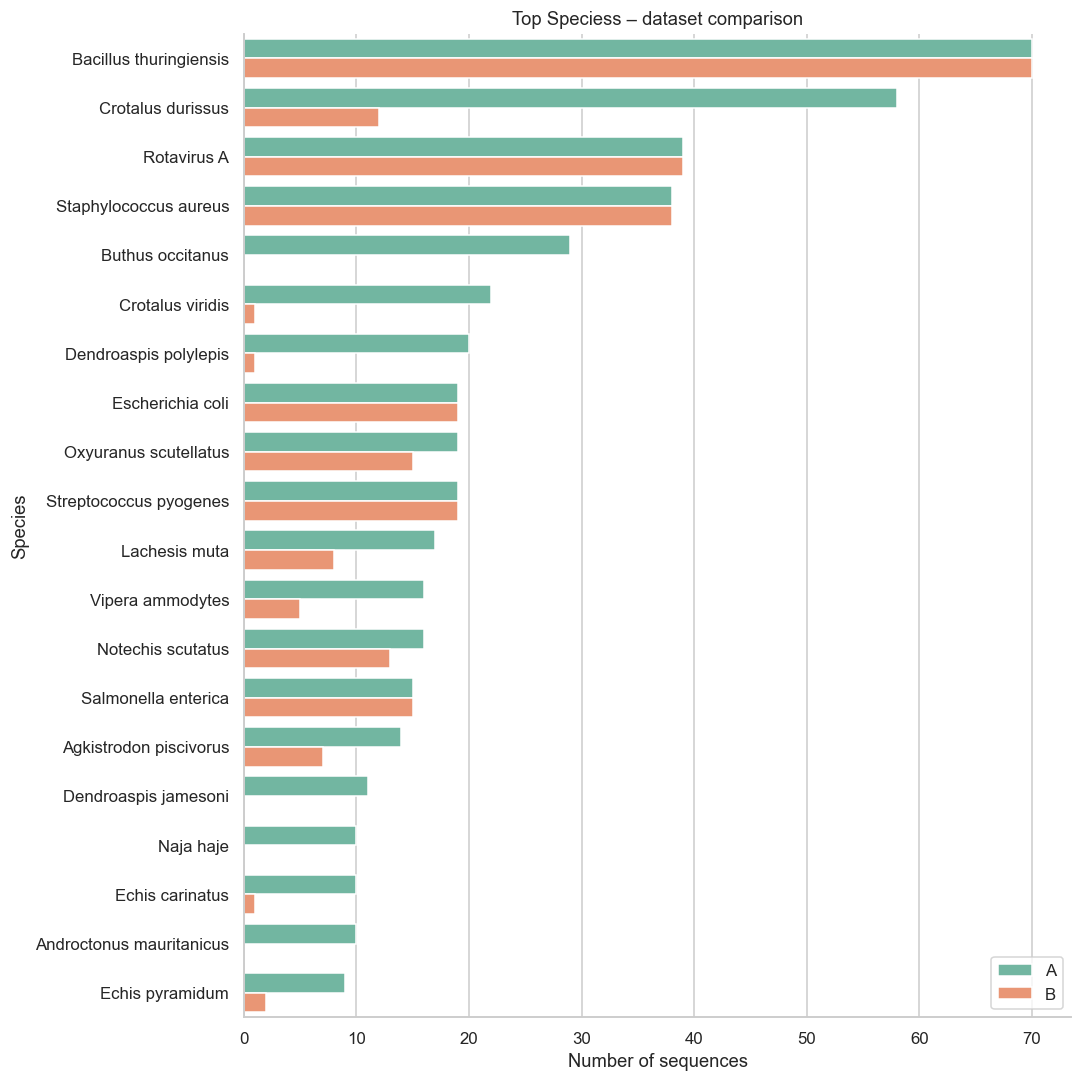

In [14]:
tox_fam, nontox_fam = filter_by_top_taxa(
    df_tox, df_non_tox,
    rank="species",
    n_top=20,
    lineage_col="Taxonomic lineage",
    match_counts=True     # False if you just want to keep *all* matches
)

print("sizes ➜", len(tox_fam), len(nontox_fam))

# 2. visual check
compare_family_bars(tox_fam, nontox_fam, rank="species")

In [17]:
from pathlib import Path
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag

OBO_PATH = Path("datasets\go-basic.obo")
if not OBO_PATH.exists():                     # download once, ~55 MB
    OBO_PATH.parent.mkdir(parents=True, exist_ok=True)
    download_go_basic_obo(str(OBO_PATH))

# parse once; serialise to speed up subsequent sessions if you like
GO_DAG = GODag(str(OBO_PATH))


def go_namespace(go_id: str) -> str | None:
    """Return 'molecular_function' | 'biological_process' | 'cellular_component'
    or None if the GO ID is missing from the DAG."""
    node = GO_DAG.get(go_id)
    return node.namespace if node else None


# -------------------------------------------------------------------- #
# 1. generic helpers (explode GO list, etc.)
# -------------------------------------------------------------------- #
import re, pandas as pd, numpy as np
from collections import Counter

_r_go_split = re.compile(r";\s*")           # same splitter as before


def explode_go(df: pd.DataFrame,
               go_col: str = "Gene Ontology IDs") -> pd.DataFrame:
    """Return long-form dataframe with one GO ID per row."""
    return (
        df.assign(GO=df[go_col].str.split(_r_go_split))
          .explode("GO")
          .dropna(subset=["GO"])
          .reset_index(drop=True)
    )

#offline molecular func balancer
def downsample_by_molfunc(src: pd.DataFrame,
                          ref: pd.DataFrame,
                          n_terms: int = 30,
                          go_col: str = "Gene Ontology IDs",
                          random_state: int = 0):
    """
    Return (src_balanced, ref_trimmed) where src_balanced is down-sampled so its
    *molecular-function* GO distribution matches that of ref_trimmed on the top
    `n_terms` MF terms present in the reference dataframe.
    """

    rng = np.random.default_rng(random_state)

    # 1 ) explode and keep only MF rows
    src_long = explode_go(src, go_col)
    ref_long = explode_go(ref, go_col)
    src_long["Aspect"] = src_long["GO"].map(go_namespace)
    ref_long["Aspect"] = ref_long["GO"].map(go_namespace)

    mf_src = src_long[src_long["Aspect"] == "molecular_function"]
    mf_ref = ref_long[ref_long["Aspect"] == "molecular_function"]

    # 2 ) choose top-N MF terms in the *reference* set
    top_mf = (mf_ref["GO"].value_counts()
                        .head(n_terms)
                        .index.tolist())

    # 3 ) slice each dataframe to those terms
    keep_src = mf_src[mf_src["GO"].isin(top_mf)].index
    keep_ref = mf_ref[mf_ref["GO"].isin(top_mf)].index
    slice_src = src.loc[keep_src]
    slice_ref = ref.loc[keep_ref]

    # 4 ) down-sample src so each MF term matches ref’s count
    matched_rows = []
    ref_counts = mf_ref[mf_ref["GO"].isin(top_mf)]["GO"].value_counts()
    for go_id, n_needed in ref_counts.items():
        pool = slice_src[slice_src[go_col].str.contains(go_id, regex=False)]
        if len(pool) >= n_needed:
            matched_rows.append(pool.sample(n_needed, random_state=rng))
        else:                         # keep all available if fewer than needed
            matched_rows.append(pool)
    src_balanced = pd.concat(matched_rows, ignore_index=True)

    return src_balanced, slice_ref.reset_index(drop=True)

datasets\go-basic.obo: fmt(1.2) rel(2025-07-22) 43,230 Terms


In [18]:
non_tox_mf, tox_mf = downsample_by_molfunc(
    src=nontox_fam,      # set you want to trim / balance
    ref=tox_fam,          # reference whose MF profile you trust
    n_terms=40
)

print(len(tox_mf), len(non_tox_mf)) 

KeyError: '[267, 302, 333, 344, 351, 357, 366, 393, 407, 408, 417, 423, 428, 432, 454, 459, 465, 473, 481, 485, 491, 509, 528, 549, 554, 575, 592, 600, 610, 626, 634, 701, 715, 720, 749, 751, 763, 794, 795, 799, 801, 802, 803, 808, 811, 812, 816, 818, 819, 820, 825, 828, 829, 836, 842, 844, 846, 850, 853, 855, 908, 912, 926, 927, 928, 936, 950, 964, 966, 972, 980, 982, 984, 985, 989, 991, 992, 996, 998, 999, 1003, 1005, 1006, 1010, 1014, 1015, 1016, 1020, 1022, 1025, 1031, 1037, 1039, 1043, 1046, 1048, 1054, 1090, 1106, 1107, 1112, 1114, 1115, 1120, 1125, 1127, 1133, 1141, 1148, 1151, 1157, 1158, 1163, 1170, 1171, 1176] not in index'